In [1]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from math import sqrt
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
%matplotlib inline



def data_process(test=False):
    
    
    # Read file for train or test.
    
    df_raw_train = pd.read_csv('train.csv',index_col=0)
    df_raw_test = pd.read_csv('test.csv',index_col=0)

    
    # Remove outliers in training set.   
    outlier_list_scatter = [524, 1299]
    outlier_list_hard_to_fit = [463, 31, 534, 1433, 739, 1159, 108, 1231, 971, 1424 ]
    outlier_list = outlier_list_scatter + outlier_list_hard_to_fit
    df_raw_train = df_raw_train.drop(outlier_list)
    
    # Store the sale price information
    sale_price_train = df_raw_train['SalePrice']
    
    # Merge train and test df together for later process
    df_processed = pd.concat([df_raw_train, df_raw_test], sort=True)
    

    # Combine bathroom quanlitity 
    df_processed['BsmtBath'] = df_processed.BsmtFullBath + df_processed.BsmtHalfBath * 0.5
    df_processed['Bath'] = df_processed.FullBath + df_processed.HalfBath * 0.5
       
    
    ## Drop multicollinear columns 
    df_processed = df_processed.drop(['BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath'], axis=1)
    
    
    ## Missing values
    
    # 259 LotFrontage  - replace missing value with 0 
#     df_processed.LotFrontage = df_processed.LotFrontage.fillna(0)
    df_processed["LotFrontage"] = df_processed.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # 1369 Alley - replace with None
    df_processed.Alley = df_processed.Alley.fillna('None')

    # 8 MasVnrType and MasVnrArea - replace MasVnrType with None and MasVnrArea with 0
    df_processed.MasVnrType = df_processed.MasVnrType.fillna('None')
    df_processed.MasVnrArea = df_processed.MasVnrArea.fillna(0)

    # 37 basement: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2- replace with None
    df_processed.BsmtQual = df_processed.BsmtQual.fillna('None')
    df_processed.BsmtCond = df_processed.BsmtCond.fillna('None')
    df_processed.BsmtExposure = df_processed.BsmtExposure.fillna('None')
    df_processed.BsmtFinType1 = df_processed.BsmtFinType1.fillna('None')
    df_processed.BsmtFinType2 = df_processed.BsmtFinType2.fillna('None')
    df_processed.TotalBsmtSF = df_processed.TotalBsmtSF.fillna(0)
    

    # 690 FireplaceQu - replace with None
    df_processed.FireplaceQu = df_processed.FireplaceQu.fillna('None')

    # 81 Garage: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond - replace with None and year with 0 
    df_processed.GarageType = df_processed.GarageType.fillna('None')
    df_processed.GarageFinish = df_processed.GarageFinish.fillna('None')
    df_processed.GarageQual = df_processed.GarageQual.fillna('None')
    df_processed.GarageCond = df_processed.GarageCond.fillna('None')
    df_processed.GarageYrBlt = df_processed.GarageYrBlt.fillna(0)

    # 1453 PoolQC - replace with None
    df_processed.PoolQC = df_processed.PoolQC.fillna('None')

    # 1179 Fence - replace with None
    df_processed.Fence = df_processed.Fence.fillna('None')

    # 1406 MiscFeature - replace with None    
    df_processed.MiscFeature = df_processed.MiscFeature.fillna('None')

    # 1 Electrical
    df_processed = df_processed[pd.notnull(df_processed.Electrical)]
    
    #Missing Value only in test data 
    
    # MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
    df_processed['MSZoning'] = df_processed['MSZoning'].fillna(df_processed['MSZoning'].mode()[0])

    # Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
    df_processed.drop(['Utilities'], axis=1,inplace=True)

    # Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    df_processed['Exterior1st'] = df_processed['Exterior1st'].fillna(df_processed['Exterior1st'].mode()[0])
    df_processed['Exterior2nd'] = df_processed['Exterior2nd'].fillna(df_processed['Exterior2nd'].mode()[0]) 
    
    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtBath : missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtBath'):
        df_processed[col] = df_processed[col].fillna(0)    
    
    #Garage Cars 
    df_processed.GarageCars = df_processed.GarageCars.fillna(0) 
    
    # SaleType : Fill in again with most frequent which is "WD"
    df_processed['SaleType'] = df_processed['SaleType'].fillna(df_processed['SaleType'].mode()[0])
    
    # KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
    df_processed['KitchenQual'] = df_processed['KitchenQual'].fillna(df_processed['KitchenQual'].mode()[0])    
    
    # Functional : data description says NA means typical
    df_processed["Functional"] = df_processed["Functional"].fillna("Typ")    
    

    # drop GarageArea - higher correlation than GarageACars, results are better as well
    df_processed = df_processed.drop(['GarageArea'], axis=1) 
    df_processed = df_processed.drop(['MiscFeature'], axis=1) 
#     df_processed = df_processed.drop(['1stFlrSF'], axis=1) 
    df_processed = df_processed.drop(['TotRmsAbvGrd'], axis=1) 

    
    # Feature Transformation - take the logarithm of the features.
    #Linear_Num_Cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'GarageArea', 'TotRmsAbvGrd', 'TotalSF', 'BsmtFinSF1']
    df_processed.GrLivArea = np.log(df_processed.GrLivArea)
    df_processed.TotalBsmtSF = np.log(df_processed.TotalBsmtSF+1)
#     df_processed.LotArea = np.log(df_processed.LotArea) -- performance decreases
#     df_processed.GarageArea = np.log(df_processed.GarageArea) -- will drop column 



    # Categorical Features Processsing

    # MSSubClass processing - MSSubClass 20-90 contains only duplicate information with HouseStyle and YearBuilt.
    df_processed['MSSubClass'] = df_processed['MSSubClass'].replace(['20','30','40','45','50','60','70','75','80','85'], '0')

    # Convert numerical to categorical. 
    df_processed['MSSubClass'] = df_processed['MSSubClass'].astype(str)

    #Encode some categorical features as ordered numbers when there is information in the order.
    df_processed = df_processed.replace({"Alley" : {"None":0,"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0,"No":1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 3, "Mod" : 2, "Gtl" : 1},
                       "LotShape" : {"IR3" : 4, "IR2" : 3, "IR1" : 2, "Reg" : 1},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2}})
    

    
    # Year processing 
    # Combine year sold with year build to year old
    df_processed['YearsOld']  = df_processed['YrSold'] - df_processed['YearBuilt']
    df_processed = df_processed.drop(['YearBuilt'], axis=1)

    # Combine YrSold and YearRemodAdd
    df_processed['YearSinceRemodel'] = df_processed['YrSold'] - df_processed['YearRemodAdd']
    df_processed = df_processed.drop(['YearRemodAdd'], axis=1)
    df_processed = df_processed.drop(['YrSold'], axis=1)
    
    # Missing rate greater than 47%, and low correlation with sale price
    df_processed = df_processed.drop(['FireplaceQu'], axis=1)

    # PoolQC has .99 missing value. drop will lower rmse
    df_processed = df_processed.drop(['PoolQC'], axis=1)
    
#     MiscVal is 0 when MiscFeature is missing. drop will lower rmse a little
#     df_processed = df_processed.drop(['MiscVal'], axis=1)
    
    #Get Dummies 
    #df_processed = pd.get_dummies(df_processed, columns=df_processed.select_dtypes(include=['object']).columns, drop_first=True)

    #get label encoder. categorical data change to numerical values
    # if label_encode:
    le = preprocessing.LabelEncoder()
    categorical_col=df_processed.select_dtypes(include=['O']).columns.to_list()
    
    for col in categorical_col: 
        le.fit(df_processed[col])
        df_processed[col] = le.fit_transform(df_processed[col])   
        
    # Split train and test data sets
    df_processed_train = df_processed[df_processed.index <= 1460].copy()
    df_processed_test = df_processed[df_processed.index > 1460].copy()
    
    # take log on price
    sale_price_train = np.log(sale_price_train)
    df_processed_train['SalePrice'] = sale_price_train    
    

    
    if test is False:
        return df_processed_train
    if test is True:
        return df_processed_test

In [2]:
train_processed=data_process()
test_processed=data_process(True)
test_processed_x = test_processed.drop(['SalePrice'], axis=1)


In [3]:
##Add MLFLOW

import os
import warnings
import sys

import mlflow
import mlflow.sklearn


import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


#Randomized search CV with Random Forrest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import numpy as np
import math

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    r2_test = r2_score(actual, pred)
    return rmse, r2_test

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(train_processed)

# The predicted column is "SalePrice" .
train_x = train.drop(["SalePrice"], axis=1)
test_x = test.drop(["SalePrice"], axis=1)
train_y = train[["SalePrice"]]
test_y = test[["SalePrice"]]

def random_search_rf(n_estimators,
                     max_features, max_depth,
                     min_samples_split,min_samples_leaf):

    
    # Execute random forest
    with mlflow.start_run():
        
        rf = RandomForestRegressor(oob_score=True)


        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                      }
        print(random_grid)
        
        # First create the base model to tune
        rf = RandomForestRegressor()

        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
        rf_random.fit(train_x, train_y.values.ravel())

        print('random forrest best_params per random search')
        print (rf_random.best_params_)


        best_n_estimator=rf_random.best_params_.get('n_estimators')
        best_max_features=rf_random.best_params_.get("max_features")
        best_max_depth=rf_random.best_params_.get('max_depth')
        best_min_samples_split=rf_random.best_params_.get('min_samples_split')
        best_min_samples_leaf=rf_random.best_params_.get("min_samples_leaf")
    

        #Train random forest based on the best parameters found
        rf = RandomForestRegressor( n_estimators=best_n_estimator,
                    max_features=best_max_features,
                    max_depth=best_max_depth,
                    min_samples_split=best_min_samples_split,
                    min_samples_leaf=best_min_samples_leaf,
                    oob_score =True)


        # Train the model on train.csv data
        rf.fit(train_x, train_y.values.ravel())
        y_pred_train = rf.predict(train_x)
        
        # Evaluate Metrics
        predicted_qualities = rf.predict(test_x)
        (rmse, r2_test) = eval_metrics(test_y, predicted_qualities)
        

        print (test_x.shape)
        print (test_processed_x.shape)
        #Predict the sales from test.csv
        y_pred_test = rf.predict(test_processed_x)

        

        mae = mean_absolute_error(train_y['SalePrice'].to_numpy(), y_pred_train)
        print ('best model parameter mae:', mae)
        
        #train r2
        r2 = r2_score(train_y['SalePrice'].to_numpy(), y_pred_train)
        print ('r2_train:', r2)
        
        oob = rf.oob_score_
        print('Oob score: ',oob)
        oob_pred = rf.oob_prediction_
        rmse_oob = math.sqrt(sum((train_y['SalePrice'].to_numpy()-oob_pred)**2)/len(train_x))
        print('Rmse using oob prediction: ', rmse_oob)
        
        
        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("model", 'random_forest')
        mlflow.log_param("n_estimators", best_n_estimator)
        mlflow.log_param("max_features", best_max_features)
        mlflow.log_param("max_depth", best_max_depth)
        mlflow.log_param("min_samples_split", best_min_samples_split)
        mlflow.log_param("min_samples_leaf", best_min_samples_leaf)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_train", r2)
        mlflow.log_metric("r2_test", r2_test)
        mlflow.log_metric("oob", oob)
  
        #mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(rf, "model")
        
    #Save Submisssion-------------------------------------------------------------------------------------------------------------------------
    file_name = './submissions'+'_rf_rand_'+str(best_n_estimator)+'_'+str(best_max_features)+'_'+str(best_max_depth)+'_'+str("best_min_samples_split")+'_'+str(rmse)+'.csv'
    submission = pd.DataFrame({'Id':list(range(1461,2920)),'SalePrice':y_pred_test})
    submission.to_csv(file_name,index=False)
        
    return (rmse, mae, r2, oob, rmse_oob,best_n_estimator,best_max_features, best_max_depth,best_min_samples_split,best_min_samples_leaf)


In [ ]:
#run random_search_rf function with start parameters 



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, 
                                            stop = 2000, 
                                            num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(start = 35, stop = 50, num = 2)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(11,300, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4, 5,6,7,8,9,10,11,12,13,14,15]


random_search_rf(n_estimators,max_features, max_depth,min_samples_split,min_samples_leaf)

In [ ]:
# ##Add MLFLOW, grid search with random forrest
# import mlflow
# import mlflow.sklearn
# import math
# import logging
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)


# #Grid Search with Random Forrest

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import os
# import warnings
# import sys
# from sklearn.model_selection import GridSearchCV

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split



# def grid_search_rf(n_estimators,max_features, max_depth,min_samples_split,min_samples_leaf):
#     # Execute random forest
#     with mlflow.start_run():
        
#         rf = RandomForestRegressor(oob_score=True)


#         # Create the random grid
#         grid = {'n_estimators': n_estimators,
#                        'max_features': max_features,
#                        'max_depth': max_depth,
#                        'min_samples_split': min_samples_split,
#                        'min_samples_leaf': min_samples_leaf,
#                       }

#         # Use the random grid to search for best hyperparameters
#         # First create the base model to tune
#         rf = RandomForestRegressor()
#         # Random search of parameters, using 3 fold cross validation, 
#         # search across 100 different combinations, and use all available cores
#         rf_grid = GridSearchCV(estimator = rf, param_grid = grid, verbose=2, n_jobs = -1)# Fit the random search model
#         rf_grid.fit(train_x, train_y.values.ravel())

#         print('random forrest best_params per random search')
#         print (rf_grid.best_params_)


#         best_n_estimator=rf_grid.best_params_.get('n_estimators')
#         best_max_features=rf_grid.best_params_.get("max_features")
#         best_max_depth=rf_grid.best_params_.get('max_depth')
#         best_min_samples_split=rf_grid.best_params_.get('min_samples_split')
#         best_min_samples_leaf=rf_grid.best_params_.get("min_samples_leaf")

#         #Train random forest based on the best parameters found
#         rf = RandomForestRegressor( n_estimators=best_n_estimator,
#                     max_features=best_max_features,
#                    max_depth=best_max_depth,
#                    min_samples_split=best_min_samples_split,
#                    min_samples_leaf=best_min_samples_leaf,
#                    oob_score =True)

#         # Train the model on train.csv data
#         rf.fit(train_x, train_y.values.ravel())
#         y_pred_train = rf.predict(train_x)

#         y_pred_test = rf.predict(test_processed_x)

#         #calculate rsme for train data
#         rmse = math.sqrt(sum((train_y['SalePrice'].to_numpy()-y_pred_train)**2)/len(train_x))
#         print('best model parameter Rmse: ',rmse)

#         mae = mean_absolute_error(train_y['SalePrice'].to_numpy(), y_pred_train)
#         print ('best model parameter mae:', mae)

#         r2 = r2_score(train_y['SalePrice'].to_numpy(), y_pred_train)
#         print ('best model r2 score:', r2)

#         oob = rf.oob_score_
#         print('best model parameter Oob score: ',oob)
#         oob_pred = rf.oob_prediction_
#         rmse_oob = math.sqrt(sum((train_y['SalePrice'].to_numpy()-oob_pred)**2)/len(train_x))
#         print('Rmse using oob prediction: ', rmse_oob)

# #     #Save Submisssion-------------------------------------------------------------------------------------------------------------------------
# #     file_name = './submissions'+'_rf_grid_'+str(best_n_estimator)+'_'+str(best_max_features)+'_'+str(best_max_depth)+'_'+str("best_min_samples_split")+'_'+str(rmse)+'.csv'
# #     submission = pd.DataFrame({'Id':list(range(1461,2920)),'SalePrice':y_pred_test})
# #     submission.to_csv(file_name,index=False)
    
#     #Return Feature Importance-------------------------------------------------------------------------------------------------------------------------
#     features = list(zip(list(train_x.columns.values),list(rf.feature_importances_)))
#     featureImportance = pd.DataFrame(features).sort_values(by =1,ascending=False)
#     featureImportance = featureImportance.rename(columns = {0:'Feature',1:'Frequency_in_Splits'})
#     featureImportance = featureImportance[featureImportance['Frequency_in_Splits']!=0]

#     return (rmse, mae, r2, oob, rmse_oob,best_n_estimator,best_max_features, best_max_depth,best_min_samples_split,best_min_samples_leaf, featureImportance)




In [ ]:
# # #Run grid search for random forest

# # # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 600, stop = 800, num = 10)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(start = 30, stop = 60, num = 2)]
# # Maximum number of levels in tree
# max_depth = [109,110,111]
# # Minimum number of samples required to split a node
# min_samples_split = [3,4,5,6,7]
# # Minimum number of samples required at each leaf node
# min_samples_leaf  = [1,4,5,6]

# grid_search_rf(n_estimators,max_features, max_depth,min_samples_split,min_samples_leaf)

In [ ]:
# ## random forrest ONLY
# import mlflow
# import mlflow.sklearn
# import math
# import logging
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)



# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import os
# import warnings
# import sys

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# ##Add MLFLOW

# import os
# import warnings
# import sys

# import mlflow
# import mlflow.sklearn


# import logging
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)



# def rf(n_estimators,max_features, max_depth, min_samples_split, min_samples_leaf):
#     # Execute random forest
#     with mlflow.start_run():
        
#         rf = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features, 
#                                    max_depth=max_depth,
#                                    min_samples_split=min_samples_split,
#                                    min_samples_leaf=min_samples_leaf,
#                                    oob_score=True)

#         # Train the model on train.csv data
#         rf.fit(train_x, train_y.values.ravel())
#         y_pred_train = rf.predict(train_x)
        
#         y_pred_train=rf.predict(test_processed_x)
        
#         # Evaluate Metrics
#         predicted_qualities = rf.predict(test_x)
#         (rmse, r2_test) = eval_metrics(test_y, predicted_qualities)

#         #calculate rsme for train data
# #         rmse = math.sqrt(sum((train_y['SalePrice'].to_numpy()-y_pred_train)**2)/len(train_x))
#         print('best model parameter Rmse: ',rmse)

#         mae = mean_absolute_error(train_y['SalePrice'].to_numpy(), y_pred_train)
#         print ('best model parameter mae:', mae)

#         r2 = r2_score(train_y['SalePrice'].to_numpy(), y_pred_train)
#         print ('best model r2 score:', r2)

#         oob = rf.oob_score_
#         print('best model parameter Oob score: ',oob)
#         oob_pred = rf.oob_prediction_
#         rmse_oob = math.sqrt(sum((train_y['SalePrice'].to_numpy()-oob_pred)**2)/len(train_x))
#         print('Rmse using oob prediction: ', rmse_oob)
        
        
#         # Log parameter, metrics, and model to MLflow
#         mlflow.log_param("model", 'random_forest')
#         mlflow.log_param("n_estimators", n_estimators)
#         mlflow.log_param("max_features", max_features)
#         mlflow.log_param("max_depth", max_depth)
#         mlflow.log_param("min_samples_split", min_samples_split)
#         mlflow.log_param("min_samples_leaf", min_samples_leaf)
        
#         mlflow.log_metric("rmse", rmse)
#         mlflow.log_metric("r2_train", r2)
#         mlflow.log_metric("r2_test", r2_test)
#         mlflow.log_metric("oob", oob)
  
#         #mlflow.log_metric("mae", mae)

#         mlflow.sklearn.log_model(rf, "model")
        

#     #Save Submisssion-------------------------------------------------------------------------------------------------------------------------
#     file_name = './submissions'+'_rf_grid_'+str(n_estimators)+'_'+str(max_features)+'_'+str(max_depth)+'_'+str(rmse)+'.csv'
#     submission = pd.DataFrame({'Id':list(range(1461,2920)),'SalePrice':y_pred_test})
#     submission.to_csv(file_name,index=False)
    
#     #Return Feature Importance-------------------------------------------------------------------------------------------------------------------------
#     features = list(zip(list(train_x.columns.values),list(rf.feature_importances_)))
#     featureImportance = pd.DataFrame(features).sort_values(by =1,ascending=False)
#     featureImportance = featureImportance.rename(columns = {0:'Feature',1:'Frequency_in_Splits'})
#     featureImportance = featureImportance[featureImportance['Frequency_in_Splits']!=0]

#     return (rmse, mae, r2, oob, rmse_oob,featureImportance)



In [47]:
#random forest only
##Add MLFLOW

import os
import warnings
import sys

import mlflow
import mlflow.sklearn


import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


#Randomized search CV with Random Forrest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import numpy as np
import math

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    r2_test = r2_score(actual, pred)
    return rmse, r2_test

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(train_processed)

# The predicted column is "SalePrice" .
train_x = train.drop(["SalePrice"], axis=1)
test_x = test.drop(["SalePrice"], axis=1)
train_y = train[["SalePrice"]]
test_y = test[["SalePrice"]]

def rf(n_estimators,
                     max_features, max_depth,
                     min_samples_split,min_samples_leaf):

    
    # Execute random forest
    with mlflow.start_run():
        
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   max_features=max_features, 
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   oob_score=True)


        # Train the model on train.csv data
        rf.fit(train_x, train_y.values.ravel())
        y_pred_train = rf.predict(train_x)
        
        # Evaluate Metrics
        predicted_qualities = rf.predict(test_x)
        (rmse, r2_test) = eval_metrics(test_y, predicted_qualities)
        
        #Predict the sales from test.csv
        y_pred_test = rf.predict(test_processed_x)

        
        #calculate rsme for train data
# #         rmse = math.sqrt(sum((train_y['SalePrice'].to_numpy()-y_pred_train)**2)/len(train_x))
#         print('Rmse: ',rmse)

        mae = mean_absolute_error(train_y['SalePrice'].to_numpy(), y_pred_train)
        print ('mae:', mae)

        r2 = r2_score(train_y['SalePrice'].to_numpy(), y_pred_train)

        oob = rf.oob_score_
        oob_pred = rf.oob_prediction_
        rmse_oob = math.sqrt(sum((train_y['SalePrice'].to_numpy()-oob_pred)**2)/len(train_x))

        
        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("model", 'random_forest')
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        mlflow.log_param("min_samples_leaf", min_samples_leaf)
        
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_train", r2)
        mlflow.log_metric("r2_test", r2_test)
        mlflow.log_metric("oob" , oob)
  
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(rf, "model")
        
        
        
        
        print("model", 'random_forest')
        print("n_estimators", n_estimators)
        print("max_features", max_features)
        print("max_depth", max_depth)
        print("min_samples_split", min_samples_split)
        print("min_samples_leaf", min_samples_leaf)
        
        
        print("rmse", rmse)
        print("r2_train", r2)
        print("r2_test", r2_test)
        print("oob", oob)
        print ('oob RMSE', rmse_oob)
    #Save Submisssion-------------------------------------------------------------------------------------------------------------------------
    file_name = './submissions'+'_rf_grid_'+str(n_estimators)+'_'+str(max_features)+'_'+str(max_depth)+'_'+str(rmse)+'.csv'
    submission = pd.DataFrame({'Id':list(range(1461,2920)),'SalePrice':y_pred_test})
    submission.to_csv(file_name,index=False)
    
    #Return Feature Importance-------------------------------------------------------------------------------------------------------------------------
    features = list(zip(list(train_x.columns.values),list(rf.feature_importances_)))
    featureImportance = pd.DataFrame(features).sort_values(by =1,ascending=False)
    featureImportance = featureImportance.rename(columns = {0:'Feature',1:'Feature Importance'})
    featureImportance = featureImportance[featureImportance['Feature Importance']!=0]


    return (rmse, mae, r2, oob, rmse_oob,n_estimators,max_features, max_depth, min_samples_split,min_samples_leaf,featureImportance)


In [48]:
rmseL=[]
maeL=[]
r2L=[]
oobL=[]
rmse_oobL=[]
n_estimatorsL=[]
max_featuresL=[]
max_depthL=[]
min_samples_splitL=[]
min_samples_leafL=[]
featureImportanceL=[]
# n_estimators1=800
# max_features1=35
# max_depth1=68
# min_samples_split1=2
# min_samples_leaf1=5


for n_estimators1 in range (700,800,10):
    for max_features1 in range (25, 41,5):
        for max_depth1 in range (50,100,4):
            for min_samples_split1 in range (2,20,3):
                for min_samples_leaf1 in range(3,10,10):
                    rmse, mae, r2, oob, rmse_oob,n_estimators,max_features, max_depth, min_samples_split,min_samples_leaf,featureImportance=rf(n_estimators=n_estimators1,max_features=max_features1, max_depth=max_depth1,min_samples_split=min_samples_split1,min_samples_leaf=min_samples_leaf1)
                    rmseL.append(rmse)
                    maeL.append(mae)
                    r2L.append(r2)
                    oobL.append(oob)
                    rmse_oobL.append(rmse_oob)
                    n_estimatorsL.append(n_estimators)
                    max_featuresL.append(max_features)
                    max_depthL.append(max_depth)
                    min_samples_splitL.append(min_samples_split)
                    min_samples_leafL.append(min_samples_leaf)
                    featureImportanceL.append(featureImportance)
                    

mae: 0.047700188718317584
model random_forest
n_estimators 700
max_features 25
max_depth 50
min_samples_split 2
min_samples_leaf 3
rmse 0.1234246257005989
r2_train 0.9665074020449539
r2_test 0.8885007835858028
oob 0.894048970277044
oob RMSE 0.13137653865722268
mae: 0.04773926748171227
model random_forest
n_estimators 700
max_features 25
max_depth 50
min_samples_split 5
min_samples_leaf 3
rmse 0.1247437442451505
r2_train 0.9662555491890132
r2_test 0.8861047194894991
oob 0.894026550006355
oob RMSE 0.13139043820005414
mae: 0.05103069459055487
model random_forest
n_estimators 700
max_features 25
max_depth 50
min_samples_split 8
min_samples_leaf 3
rmse 0.12386725664557147
r2_train 0.9619854477837402
r2_test 0.8876996225658658
oob 0.8938512455143133
oob RMSE 0.1314990683158523
mae: 0.05604552455933509
model random_forest
n_estimators 700
max_features 25
max_depth 50
min_samples_split 11
min_samples_leaf 3
rmse 0.12494727261687302
r2_train 0.9554079220219297
r2_test 0.8857327596481824
oob 0.8

mae: 0.05074742537105189
model random_forest
n_estimators 700
max_features 25
max_depth 70
min_samples_split 8
min_samples_leaf 3
rmse 0.12484399933256157
r2_train 0.9622321371142742
r2_test 0.885921573314715
oob 0.8937591045830845
oob RMSE 0.13155612889292587
mae: 0.05582631429445602
model random_forest
n_estimators 700
max_features 25
max_depth 70
min_samples_split 11
min_samples_leaf 3
rmse 0.12602792948757038
r2_train 0.955780417336686
r2_test 0.8837476394454392
oob 0.8924617758712647
oob RMSE 0.13235692068605473
mae: 0.06024901811463556
model random_forest
n_estimators 700
max_features 25
max_depth 70
min_samples_split 14
min_samples_leaf 3
rmse 0.1264841356205769
r2_train 0.9492938746882514
r2_test 0.8829044766584371
oob 0.8897805995977404
oob RMSE 0.13399674431289413
mae: 0.06344266890555615
model random_forest
n_estimators 700
max_features 25
max_depth 70
min_samples_split 17
min_samples_leaf 3
rmse 0.12742546697336113
r2_train 0.9442799027857542
r2_test 0.8811550738183204
oob 

KeyboardInterrupt: 

In [32]:
# result_d={"rmse":rmseL}, {"mae":maeL}, {"r2":r2L}, 
#             {"oob":oobL}, "rmse_oob":rmse_oobL,
#             "n_estimators"=n_estimatorsL,
#             "max_features"=max_featuresL, 
#             "max_depth"=max_depthL, min_samples_split=min_samples_splitL,
#             "min_samples_leaf"=min_samples_leafL,
#             "featureImportance"=featureImportanceL}


result=pd.DataFrame(list(zip(rmseL,maeL,r2L,oobL,rmse_oobL,n_estimatorsL,max_featuresL,max_depthL,min_samples_splitL,min_samples_leafL,featureImportanceL
)),columns=["rmseL","maeL","r2L","oobL","rmse_oobL","n_estimatorsL","max_featuresL","max_depthL","min_samples_splitL","min_samples_leafL","featureImportanceL"
])

result=pd.DataFrame(result)

result.to_csv('result_random_forrest_new',index=False)
result.head()


,rmseL,maeL,r2L,oobL,rmse_oobL,n_estimatorsL,max_featuresL,max_depthL,min_samples_splitL,min_samples_leafL,featureImportanceL
0,0.159175,0.046570,0.966773,0.893749,0.124011,700,25,50,2,3,Feature Feature Importance 55 ...
1,0.159335,0.046475,0.966972,0.893598,0.124099,700,25,50,5,3,Feature Feature Importance 55 ...
2,0.160027,0.049568,0.962993,0.893905,0.123919,700,25,50,8,3,Feature Feature Importance 55 ...
3,0.161472,0.054733,0.956239,0.891392,0.125378,700,25,50,11,3,Feature Feature Importance 55 ...
4,0.164366,0.058875,0.950256,0.889764,0.126315,700,25,50,14,3,Feature Feature Importance 55 ...


In [40]:
#find the best test_rmse
result.sort_values(by='rmse_oobL', ascending=True)

,rmseL,maeL,r2L,oobL,rmse_oobL,n_estimatorsL,max_featuresL,max_depthL,min_samples_splitL,min_samples_leafL,featureImportanceL
516,0.159177,0.044834,0.969458,0.895827,0.122792,710,35,82,2,3,Feature Feature Importance 55 ...
109,0.158707,0.045677,0.968438,0.895817,0.122798,700,30,70,5,3,Feature Feature Importance 55 ...
3109,0.159709,0.044436,0.970012,0.895787,0.122815,790,40,94,5,3,Feature Feature Importance 55 ...
2983,0.159292,0.044883,0.969280,0.895758,0.122833,790,35,62,5,3,Feature Feature Importance 55 ...
1836,0.159874,0.044394,0.969985,0.895723,0.122853,750,40,78,2,3,Feature Feature Importance 55 ...
1752,0.159326,0.044926,0.969272,0.895658,0.122891,750,35,74,2,3,Feature Feature Importance 55 ...
1771,0.159609,0.045133,0.969070,0.895648,0.122897,750,35,86,5,3,Feature Feature Importance 55 ...
145,0.159781,0.045532,0.968659,0.895644,0.122900,700,30,94,5,3,Feature Feature Importance 55 ...
1254,0.159626,0.046327,0.967165,0.895641,0.122901,740,25,54,2,3,Feature Feature Importance 55 ...
2772,0.160252,0.044485,0.970187,0.895592,0.122930,780,40,78,2,3,Feature Feature Importance 55 ...


In [41]:
result.iloc[516]['featureImportanceL']

,Feature,Feature Importance
55,OverallQual,0.324953
33,GrLivArea,0.162354
20,ExterQual,0.081055
68,YearsOld,0.056172
64,TotalBsmtSF,0.044571
27,GarageCars,0.041914
38,KitchenQual,0.036563
0,1stFlrSF,0.027497
41,LotArea,0.019888
31,GarageType,0.018782


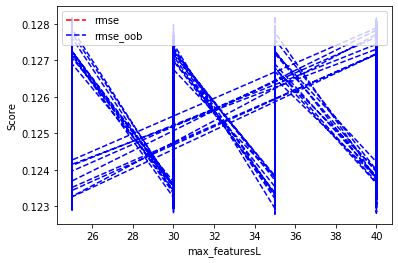

In [43]:
# #graph max depth vs Score
# train_vs_test=result.loc[:,['max_featuresL',"rmse_oobL",'train_rmse_L']]
# plt.plot('max_featuresL', 'train_rmse_L', 'r--', data=train_vs_test, label = 'rmse')
# plt.plot('max_featuresL', 'rmse_oobL', 'b--', data=train_vs_test, label = 'rmse_oob')
# plt.legend(loc='best', mode="expand")
# plt.xlabel('max_featuresL')
# plt.ylabel('Score')

# plt.show()